# SARIG rock sample lithochemistry load and data clean notebook

In this notebook we explore the very large SARIG geochemistry data package (over 10Gb).Because of the size of the initial dataset, we use the dask library to parallelise the processing of the data until we can get it to a manageable size.

Our objective is to create a 'clean', single element dataset containing only samples from drill holes. The cleaning process needs to involve:
- removing non-numeric characters
- converting oxides to elements
- dealing with below detection limit data
- converting all data to ppm
- removing/imputing null values

We can then do some further exploratory data analysis (EDA) on the output datasets to review the actual data values in them and exclude some if required. We do this in a second notebook (Max_DH_Chem_lab mapping_EDA) where we explore the various chemical methods used to determine the analyte values and review outliers by going back to the source data where we can.

Once we have cleaned the data set, we can aggregate the data, isolate the maximum values for each drill hole and plot maximum downhole chemical values accross the state.

This notebook outlines the steps taken to do the data load and clean process, using copper as an example. The 'create_chem_dataset.py' file contains the full python script to do this in bulk for all elements as well as Fe, U, Co and Ni oxides. In this notebook we also outline the aggregation process to determine the maximum value for each drill hole. This is then done, using the scripts in the 'max_dh_chem.py' file for each of the selected elements and plotted in the various 'Max_DH_element.ipynb' notebooks.

**note**
The SARIG Data Package is an extract from the Geological Survey of South Australia’s (GSSA) geoscientific database SA Geodata. SA Geodata is the primary repository for geoscientific information in South Australia and contains data collected: from research and fieldwork conducted by GSSA staff; by mineral exploration companies who are required to submit most of the data they collect during their exploration programs to the state government, and; data collected by research institutions from analysis of core and rock samples held in the South Australian Core Library. This snapshot of the database was provided for the ExploreSA: Gawler Challenge and is valid as at Feburary 2020.

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
pd.set_option('precision',5)
sns.set_style('whitegrid')

%matplotlib inline

### Load the dataset, check col headers and the numbers of different sample types 

In [2]:
# note: dask can sometimes have issues guessing the correct datatype for a column if it contains mixed types.
# Explicitly call the type if you get warnings

ddf = dd.read_csv(
    r'D:\Unearthed_SARIG_Data_Package\SARIG_Data_Package\sarig_rs_chem_exp.csv',
    dtype={"ROCK_GROUP_CODE": "object",
            "ROCK_GROUP": "object",
            "LITHO_CODE": "object",
            "LITHO_CONF": "object",
            "LITHOLOGY_NAME": "object",
            "LITHO_MODIFIER": "object",
            "MAP_SYMBOL": "object",
            "STRAT_CONF": "object",
            "STRAT_NAME": "object",
            "COLLECTORS_NUMBER": "object",
            "COLLECTED_DATE": "object",
            "DH_NAME": "object",
            "OTHER_ANALYSIS_ID": "object",
            "LABORATORY": "object",
            "VALUE": "object",
            "CHEM_METHOD_CODE": "object",
            "CHEM_METHOD_DESC": "object",})

In [3]:
ddf.columns

Index(['SAMPLE_NO', 'SAMPLE_SOURCE_CODE', 'SAMPLE_SOURCE', 'ROCK_GROUP_CODE',
       'ROCK_GROUP', 'LITHO_CODE', 'LITHO_CONF', 'LITHOLOGY_NAME',
       'LITHO_MODIFIER', 'MAP_SYMBOL', 'STRAT_CONF', 'STRAT_NAME',
       'COLLECTED_BY', 'COLLECTORS_NUMBER', 'COLLECTED_DATE',
       'DRILLHOLE_NUMBER', 'DH_NAME', 'DH_DEPTH_FROM', 'DH_DEPTH_TO',
       'SITE_NO', 'EASTING_GDA2020', 'NORTHING_GDA2020', 'ZONE_GDA2020',
       'LONGITUDE_GDA2020', 'LATITUDE_GDA2020', 'LONGITUDE_GDA94',
       'LATITUDE_GDA94', 'SAMPLE_ANALYSIS_NO', 'OTHER_ANALYSIS_ID',
       'ANALYSIS_TYPE_DESC', 'LABORATORY', 'CHEM_CODE', 'VALUE', 'UNIT',
       'CHEM_METHOD_CODE', 'CHEM_METHOD_DESC'],
      dtype='object')

In [4]:
ddf.tail(5)

,SAMPLE_NO,SAMPLE_SOURCE_CODE,SAMPLE_SOURCE,ROCK_GROUP_CODE,ROCK_GROUP,LITHO_CODE,LITHO_CONF,LITHOLOGY_NAME,LITHO_MODIFIER,MAP_SYMBOL,STRAT_CONF,STRAT_NAME,COLLECTED_BY,COLLECTORS_NUMBER,COLLECTED_DATE,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,SAMPLE_ANALYSIS_NO,OTHER_ANALYSIS_ID,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE,CHEM_METHOD_DESC
1458,2979044,DC,Drill core,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BHP BILLITON OD CORP. PTY LTD.,CR97581,13/03/1980,333098.0,RD38,852.0,858.0,2125738,679774.53,6630960.19,53,136.87211,-30.44008,136.8721,-30.44007,2485420,NaN,GEOCHEMISTRY,"AMDEL Laboratory, S.A.",Te,0.1,ppm,IC1M,Elements and detection limits by combined ICP-...
1459,2979044,DC,Drill core,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BHP BILLITON OD CORP. PTY LTD.,CR97581,13/03/1980,333098.0,RD38,852.0,858.0,2125738,679774.53,6630960.19,53,136.87211,-30.44008,136.8721,-30.44007,2485420,NaN,GEOCHEMISTRY,"AMDEL Laboratory, S.A.",Tl,0.5,ppm,IC1M,Elements and detection limits by combined ICP-...
1460,2979044,DC,Drill core,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BHP BILLITON OD CORP. PTY LTD.,CR97581,13/03/1980,333098.0,RD38,852.0,858.0,2125738,679774.53,6630960.19,53,136.87211,-30.44008,136.8721,-30.44007,2485420,NaN,GEOCHEMISTRY,"AMDEL Laboratory, S.A.",Tm,0.5,ppm,IC4R,Total fusion and analysis by inductively coupl...
1461,2979044,DC,Drill core,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BHP BILLITON OD CORP. PTY LTD.,CR97581,13/03/1980,333098.0,RD38,852.0,858.0,2125738,679774.53,6630960.19,53,136.87211,-30.44008,136.8721,-30.44007,2485420,NaN,GEOCHEMISTRY,"AMDEL Laboratory, S.A.",Yb,5,ppm,IC4R,Total fusion and analysis by inductively coupl...
1462,2979044,DC,Drill core,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BHP BILLITON OD CORP. PTY LTD.,CR97581,13/03/1980,333098.0,RD38,852.0,858.0,2125738,679774.53,6630960.19,53,136.87211,-30.44008,136.8721,-30.44007,2485420,NaN,GEOCHEMISTRY,"AMDEL Laboratory, S.A.",Zn,67,ppm,IC1M,Elements and detection limits by combined ICP-...


In [5]:
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 36 entries, SAMPLE_NO to CHEM_METHOD_DESC
dtypes: object(23), float64(9), int64(4)

Select only samples from drill holes (that have a DH number)

In [6]:
ddf_all_dh_chem = ddf.dropna(subset=['DRILLHOLE_NUMBER'])

Grab only the columns we want to reduce the size of the ddf

In [7]:
ddf_all_dh_chem = ddf_all_dh_chem[['SAMPLE_NO', 'SAMPLE_SOURCE_CODE', 'LITHO_CODE',	'MAP_SYMBOL', 'DRILLHOLE_NUMBER', 'DH_NAME', 'DH_DEPTH_FROM', 'DH_DEPTH_TO', 'SITE_NO', 'LONGITUDE_GDA2020', 'LATITUDE_GDA2020', 'SAMPLE_ANALYSIS_NO', 'ANALYSIS_TYPE_DESC', 'LABORATORY', 'CHEM_CODE', 'VALUE', 'UNIT', 'CHEM_METHOD_CODE']]

### Create Drill hole dataframe with individual DH metadata. 

First, we need to create a dataframe that contains all of the required metadata about each drill hole (e.g. its coordinates and name). We will need this dataframe later after we do some aggregation on the geochemical data, to join back to the maximum values. We can export this dataframe as a csv for use in later scripts.

In [8]:
df_DH_data = ddf_all_dh_chem[['DRILLHOLE_NUMBER', 'DH_NAME', 'SITE_NO', 'LONGITUDE_GDA2020', 'LATITUDE_GDA2020']].drop_duplicates(subset=['DRILLHOLE_NUMBER']).compute()

In [9]:
# df_DH_data.to_csv(r'D:\Python ML\SA-geochemical-maps\Data\interim\DH_data.csv', index=False)

In [10]:
df_DH_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81652 entries, 14 to 157144
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DRILLHOLE_NUMBER   81652 non-null  float64
 1   DH_NAME            81641 non-null  object 
 2   SITE_NO            81652 non-null  int64  
 3   LONGITUDE_GDA2020  81652 non-null  float64
 4   LATITUDE_GDA2020   81652 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.7+ MB


### Initial exploratory data analysis

We can now do some EDA on the dataset to see how many values and different units we have in the dataset

In [11]:
ddf_all_dh_chem.UNIT.value_counts().compute()

ppm    19939650
%       6090078
ppb      294688
g/T       41321
cps        3632
Name: UNIT, dtype: int64

The cps unit type is not compatible with the other geochemical values in this list, so we can drop those samples.

In [12]:
ddf_all_dh_chem = ddf_all_dh_chem[ddf_all_dh_chem.UNIT != 'cps']

### Select a single element

We can now compute a pandas dataframe for the unique elements of choice. Here we will select Cu. THis will sinificantly reduce the size of the dataset and allow us to use a pandas dataframe to handle the data. We will then clean up the data. 

The steps taken here to clean the data are applicable accross each of the elements and are combined in the final script.

In [13]:
df_Cu = ddf_all_dh_chem[ddf_all_dh_chem.CHEM_CODE == 'Cu'].compute()
df_Cu.to_csv(r'D:\Python ML\SA-geochemical-maps\Data\interim\all_Cu_unclean.csv',index=False)
df_Cu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1060625 entries, 10285 to 1442
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   SAMPLE_NO           1060625 non-null  int64  
 1   SAMPLE_SOURCE_CODE  1060458 non-null  object 
 2   LITHO_CODE          71561 non-null    object 
 3   MAP_SYMBOL          70726 non-null    object 
 4   DRILLHOLE_NUMBER    1060625 non-null  float64
 5   DH_NAME             1060613 non-null  object 
 6   DH_DEPTH_FROM       1060092 non-null  float64
 7   DH_DEPTH_TO         1058991 non-null  float64
 8   SITE_NO             1060625 non-null  int64  
 9   LONGITUDE_GDA2020   1060625 non-null  float64
 10  LATITUDE_GDA2020    1060625 non-null  float64
 11  SAMPLE_ANALYSIS_NO  1060625 non-null  int64  
 12  ANALYSIS_TYPE_DESC  1060625 non-null  object 
 13  LABORATORY          998847 non-null   object 
 14  CHEM_CODE           1060625 non-null  object 
 15  VALUE         

In [14]:
df_Cu.UNIT.value_counts()

ppm    938119
%      118508
ppb      3740
g/T       258
Name: UNIT, dtype: int64

### Cleaning the data

You can see from the above that we have reduced our total dataset down from over 26,000,000 samples to 1,060,625 samples. In the above you can also see that the 'VALUE' column datatype is an object. This means it probably contains a mixture of strings and floats.

We can find what symbols are contained in the 'VALUE' column.

In [15]:
sym_find_list = [re.findall(r'\D', str(i)) for i in df_Cu['VALUE']]
unique_symbols = set([item for sublist in sym_find_list for item in sublist])
unique_symbols

{'-', '.', '<', '>'}

In the SARIG geochem data:
   - '.' represents a decimal
   - '>' represents a maximum limit reached, i.e. the true value is greater than this
   - '<' is used for below detection limit
   - '-' Can be used for below detection limit, but is also sometimes used as a range, i.e. 1-10ppm. This dual use complicates things for a generic cleaning process

In [16]:
df_Cu[df_Cu['VALUE'].str.contains(r'-',na=False,regex=False)]#.info()

,SAMPLE_NO,SAMPLE_SOURCE_CODE,LITHO_CODE,MAP_SYMBOL,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,LONGITUDE_GDA2020,LATITUDE_GDA2020,SAMPLE_ANALYSIS_NO,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE
159228,1107360,CT,NaN,NaN,132836.0,MW19 DH21,34.0,36.0,120097,135.65798,-33.46568,950573,GEOCHEMISTRY,"Anglo American Research Laboratories, Johannes...",Cu,-10,g/T,XRF
2900,1107364,CT,NaN,NaN,132836.0,MW19 DH21,42.0,44.0,120097,135.65798,-33.46568,1059565,GEOCHEMISTRY,"Anglo American Research Laboratories, Johannes...",Cu,-4,g/T,XRF
3131,1107391,CT,NaN,NaN,132837.0,MW18 DH22,48.0,50.0,120098,135.64594,-33.44973,1068980,GEOCHEMISTRY,"Stockdale Prospecting Laboratory, Melbourne",Cu,-1,g/T,XRF
18397,1107394,CT,NaN,NaN,132837.0,MW18 DH22,54.0,56.0,120098,135.64594,-33.44973,1073583,GEOCHEMISTRY,Generic Laboratory codes,Cu,-36,g/T,XRF
19307,1478381,CT,NaN,NaN,132826.0,MW20 DH6,58.0,60.0,120087,135.49821,-33.30641,1073609,GEOCHEMISTRY,Generic Laboratory codes,Cu,-6,g/T,XRF
19342,1478382,CT,NaN,NaN,132826.0,MW20 DH6,60.0,62.0,120087,135.49821,-33.30641,1073610,GEOCHEMISTRY,Generic Laboratory codes,Cu,-6,g/T,XRF
19398,1478383,CT,NaN,NaN,132826.0,MW20 DH6,62.0,64.0,120087,135.49821,-33.30641,1073611,GEOCHEMISTRY,Generic Laboratory codes,Cu,-3,g/T,XRF
19412,1478384,CT,NaN,NaN,132826.0,MW20 DH6,64.0,66.0,120087,135.49821,-33.30641,1073612,GEOCHEMISTRY,Generic Laboratory codes,Cu,-3,g/T,XRF
19549,1478422,CT,NaN,NaN,132827.0,MW20 DH7,74.0,76.0,120088,135.49821,-33.30587,1073614,GEOCHEMISTRY,Generic Laboratory codes,Cu,-1,g/T,XRF
19594,1478424,CT,NaN,NaN,132827.0,MW20 DH7,78.0,80.0,120088,135.49821,-33.30587,1073616,GEOCHEMISTRY,Generic Laboratory codes,Cu,-4,g/T,XRF


In [17]:
display(df_Cu[df_Cu['VALUE'].str.contains(r'>',na=False,regex=False)].sample(5))
display(df_Cu[df_Cu['VALUE'].str.contains(r'>',na=False,regex=False)].UNIT.value_counts())

,SAMPLE_NO,SAMPLE_SOURCE_CODE,LITHO_CODE,MAP_SYMBOL,DRILLHOLE_NUMBER,DH_NAME,DH_DEPTH_FROM,DH_DEPTH_TO,SITE_NO,LONGITUDE_GDA2020,LATITUDE_GDA2020,SAMPLE_ANALYSIS_NO,ANALYSIS_TYPE_DESC,LABORATORY,CHEM_CODE,VALUE,UNIT,CHEM_METHOD_CODE
19492,2064830,CT,NaN,NaN,279489.0,WDRC220,28.0,30.0,1978391,140.57686,-32.09411,1625553,GEOCHEMISTRY,Analabs Pty Ltd.,Cu,>10000,ppm,A102
132384,2166771,CT,NaN,NaN,290583.0,ALWAC0297,57.0,58.0,2018317,137.73278,-33.87537,1705338,GEOCHEMISTRY,"ALS Chemex, Perth WA",Cu,>10000,ppm,ME-ICP61
101992,1893772,DC,NaN,NaN,23633.0,DDH 114,328.0,329.0,18950,137.66889,-33.97750,1687881,GEOCHEMISTRY,"ALS Chemex, Perth WA",Cu,>10000,ppm,ME-ICP61
19507,2064845,CT,NaN,NaN,279489.0,WDRC220,58.0,60.0,1978391,140.57686,-32.09411,1625568,GEOCHEMISTRY,Analabs Pty Ltd.,Cu,>10000,ppm,A102
164856,2167003,CT,NaN,NaN,290590.0,ALWAC0304,6.0,7.0,2018324,137.72247,-33.88087,1705570,GEOCHEMISTRY,"ALS Chemex, Perth WA",Cu,>10000,ppm,ME-ICP61


ppm    63
Name: UNIT, dtype: int64

Reviewing the data points that contain '-' and '>'. We can see above that there are only 13 samples that contain a '-' symbol, and all are very small values. There are 63 greater than detection samples, all measured in ppm.

Now that we know this we can clean up these samples and convert the 'VALUE' column back into a float datatype. Given the small numbers of samples containing '-' we will simply drop those rows.

To handle the above detection limit and below detection limit values, we will create a a new 'BDL' column which will act as a flag to indicate which rows are below DL (1) and which are above analysis limit (2). We can then strip these characters out from the 'VALUE' column and convert back to Floats.

In [18]:
df_Cu.drop(df_Cu[df_Cu.VALUE.str.contains(r'-', na=False, regex=False)].index, inplace=True)

In [19]:
# create BDL/ODL flag and remove strings from values
df_Cu["BDL"] = 0
df_Cu.loc[df_Cu["VALUE"].str.contains("<", na=False, regex=False), "BDL"] = 1
df_Cu.loc[df_Cu["VALUE"].str.contains(">", na=False, regex=False), "BDL"] = 2

df_Cu["VALUE"] = (
    df_Cu["VALUE"].astype(str).str.replace(r"[<>]", "", regex=True).astype(float)
)

Finally, there are a number of rows in the dataset which have a vaule of 0.0. We can drop these rows.

In [20]:
df_Cu = df_Cu[~(df_Cu.VALUE == 0.0)]

### Converting to like units

Now we have cleaned up the 'VALUE column, we can convert the ppb and % units to ppm in a new column called 'converted_ppm'. No need to convert the g/T as this is ppm.

In [21]:
df_Cu["converted_ppm"] = df_Cu["VALUE"]

df_Cu.loc[(df_Cu["UNIT"] == "%"), "converted_ppm"] = (
    df_Cu.loc[(df_Cu["UNIT"] == "%"), "VALUE"] * 10000
)

df_Cu.loc[(df_Cu["UNIT"] == "ppb"), "converted_ppm"] = (
    df_Cu.loc[(df_Cu["UNIT"] == "ppb"), "VALUE"] / 10000
)

### Handling BDL values

We can now convert the BDL values to something that is not going to interfere with our objective to locate the maximum values from each drill hole. Because some older analysis methods had very high detection limits, some BDL values may be larger than some low level modern analysis. There are a number of ways to do this and each has its trade offs, for example we could just drop the BDL samples, or create a 1/2 BDL value. 

In this case we don't want to loose the fact that the sample has been analysed but need to make sure it is a low value. Here we will replace the BDL values with a value of 0.001 ppm, a very low but non zero value.

In [22]:
df_Cu.loc[df_Cu["BDL"] == 1, "converted_ppm"] = 0.001

### Cleaning data based on analysis method

A final step we can do is review the data based on analysis method. Currently in the state dataset the lab methods are recorded by the specific lab codes, not by the generic lab analysis method. To overcome this we have, where possible, created a mapping from the specific lab codes to a generic determination type, digestion type and fusion type. This is the 'chem_method_code_map.csv' file. 

In the following notebook, 'Max_DH_Chem_lab mapping_EDA', we use this to review the data for each selected element in detail inorder to exclude data we are not sure about, or data that is obviously incorrect.

To add the method codes into the datset we:
- Fill the missing values in the 'CHEM_METHOD_CODE" column with a value 'unk' indicating no method information
- We use the 'chem_method_code_map.csv' file to create mapping from the 'CHEM_METHOD_CODE' to our determination, digestion and fusion values
- We create three new columns in the dataset, DETERMINATION, DIGESTION, FUSION

In [23]:
df_Cu["CHEM_METHOD_CODE"].fillna(value="unk", inplace=True)

In [24]:
chem_methods = pd.read_csv(r"D:\Python ML\SA-geochemical-maps\notebooks\chem_method_code_map.csv")

In [25]:
determination_map = chem_methods.set_index('CHEM_METHOD')['DETERMINATION_CODE_RD'].to_dict()
digestion_map = chem_methods.set_index('CHEM_METHOD')['DIGESTION_CODE_RD'].to_dict()
fusion_map = chem_methods.set_index('CHEM_METHOD')['FUSION_TYPE'].to_dict()

In [26]:
df_Cu["DETERMINATION"] = df_Cu.CHEM_METHOD_CODE.map(determination_map).fillna("unknown")
df_Cu["DIGESTION"] = df_Cu.CHEM_METHOD_CODE.map(digestion_map).fillna("unknown")
df_Cu["FUSION"] = df_Cu.CHEM_METHOD_CODE.map(fusion_map).fillna("unknown")

### Aggregating the data

Once the data has been further reviewed and cleaned based on lab method, we can create an aggregated dataset where we isolate the maximum value from each drill hole using a groupby. We then need to join that data back with the drill hole metadata to reattach the drill hole information to the new maximum value dataset.

**note**
The dataset below contains all method types and samples that may be spurious. It is just an example of the process. See the individual notebooks for the cleaned versions

In [27]:
df_agg = df_Cu.groupby(["DRILLHOLE_NUMBER"])["converted_ppm"].idxmax().reset_index()

In [28]:
df_max = df_agg.merge(df_DH_data, how="left", left_on="DRILLHOLE_NUMBER", right_on="DRILLHOLE_NUMBER")

In [29]:
df_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51948 entries, 0 to 51947
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DRILLHOLE_NUMBER   51948 non-null  float64
 1   converted_ppm      51948 non-null  int64  
 2   DH_NAME            51943 non-null  object 
 3   SITE_NO            51948 non-null  int64  
 4   LONGITUDE_GDA2020  51948 non-null  float64
 5   LATITUDE_GDA2020   51948 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ MB


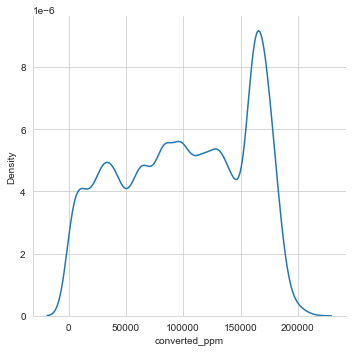

In [30]:
sns.displot(df_max, x='converted_ppm', kind='kde')

<Figure size 432x288 with 0 Axes>

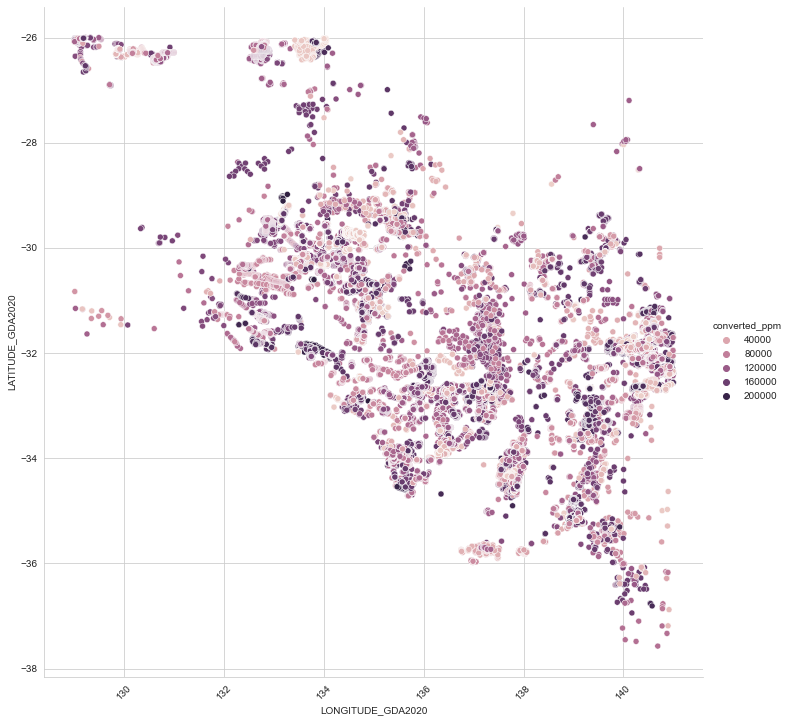

In [31]:
plt.figure()
sns.relplot(x='LONGITUDE_GDA2020', y='LATITUDE_GDA2020', hue='converted_ppm', height=10, aspect=1, data=df_max)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()